In [37]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [38]:
# Global variables
SAVE = True
SEED = 123

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [39]:
# Function for importing data           
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []
    
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)
            
    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)
            
    return data_path, data_labels


In [40]:
import os
from pathlib import Path

# Setting up file paths for training and testing
USER_PATH = r"C:\Users\rahul\Downloads\archive (1)"  # Using raw string (note the 'r' prefix)
BASE_DIR = Path(USER_PATH)

# Verify base directory exists
print(f"\nChecking base directory at: {BASE_DIR}")
print(f"Directory exists: {BASE_DIR.exists()}")
if BASE_DIR.exists():
    print("Contents:", os.listdir(BASE_DIR))

# Define training and testing paths
train_dir = BASE_DIR / "Training"  # Using pathlib for cross-platform compatibility
test_dir = BASE_DIR / "Testing"

# Verify paths before processing
print(f"\nChecking training directory at: {train_dir}")
print(f"Directory exists: {train_dir.exists()}")
if train_dir.exists():
    print("Contents:", os.listdir(train_dir)[:5])  # Show first 5 items

print(f"\nChecking testing directory at: {test_dir}")
print(f"Directory exists: {test_dir.exists()}")
if test_dir.exists():
    print("Contents:", os.listdir(test_dir)[:5])

# Only proceed if paths exist
if train_dir.exists() and test_dir.exists():
    # Getting data using above function
    train_paths, train_labels = get_data_labels(str(train_dir))  # Convert to string if needed
    test_paths, test_labels = get_data_labels(str(test_dir))

    # Printing training and testing sample sizes
    print('\nTraining Data:')
    print(f'Number of Paths: {len(train_paths)}')
    print(f'Number of Labels: {len(train_labels)}')
    print('\nTesting Data:')
    print(f'Number of Paths: {len(test_paths)}')
    print(f'Number of Labels: {len(test_labels)}')
else:
    print("\nERROR: Required directories not found. Please verify:")
    print(f"1. Base directory exists: {BASE_DIR}")
    print(f"2. Training folder exists: {train_dir}")
    print(f"3. Testing folder exists: {test_dir}")
    print("\nCheck for:")
    print("- Typos in path (e.g., 'Tumer' vs 'Tumor')")
    print("- Folder permissions")
    print("- Whether the archive was extracted correctly")


Checking base directory at: C:\Users\rahul\Downloads\archive (1)
Directory exists: True
Contents: ['Testing', 'Training']

Checking training directory at: C:\Users\rahul\Downloads\archive (1)\Training
Directory exists: True
Contents: ['glioma', 'meningioma', 'notumor', 'pituitary']

Checking testing directory at: C:\Users\rahul\Downloads\archive (1)\Testing
Directory exists: True
Contents: ['glioma', 'meningioma', 'notumor', 'pituitary']

Training Data:
Number of Paths: 5712
Number of Labels: 5712

Testing Data:
Number of Paths: 1311
Number of Labels: 1311


Training Counts
{'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}

Testing Counts
{'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}


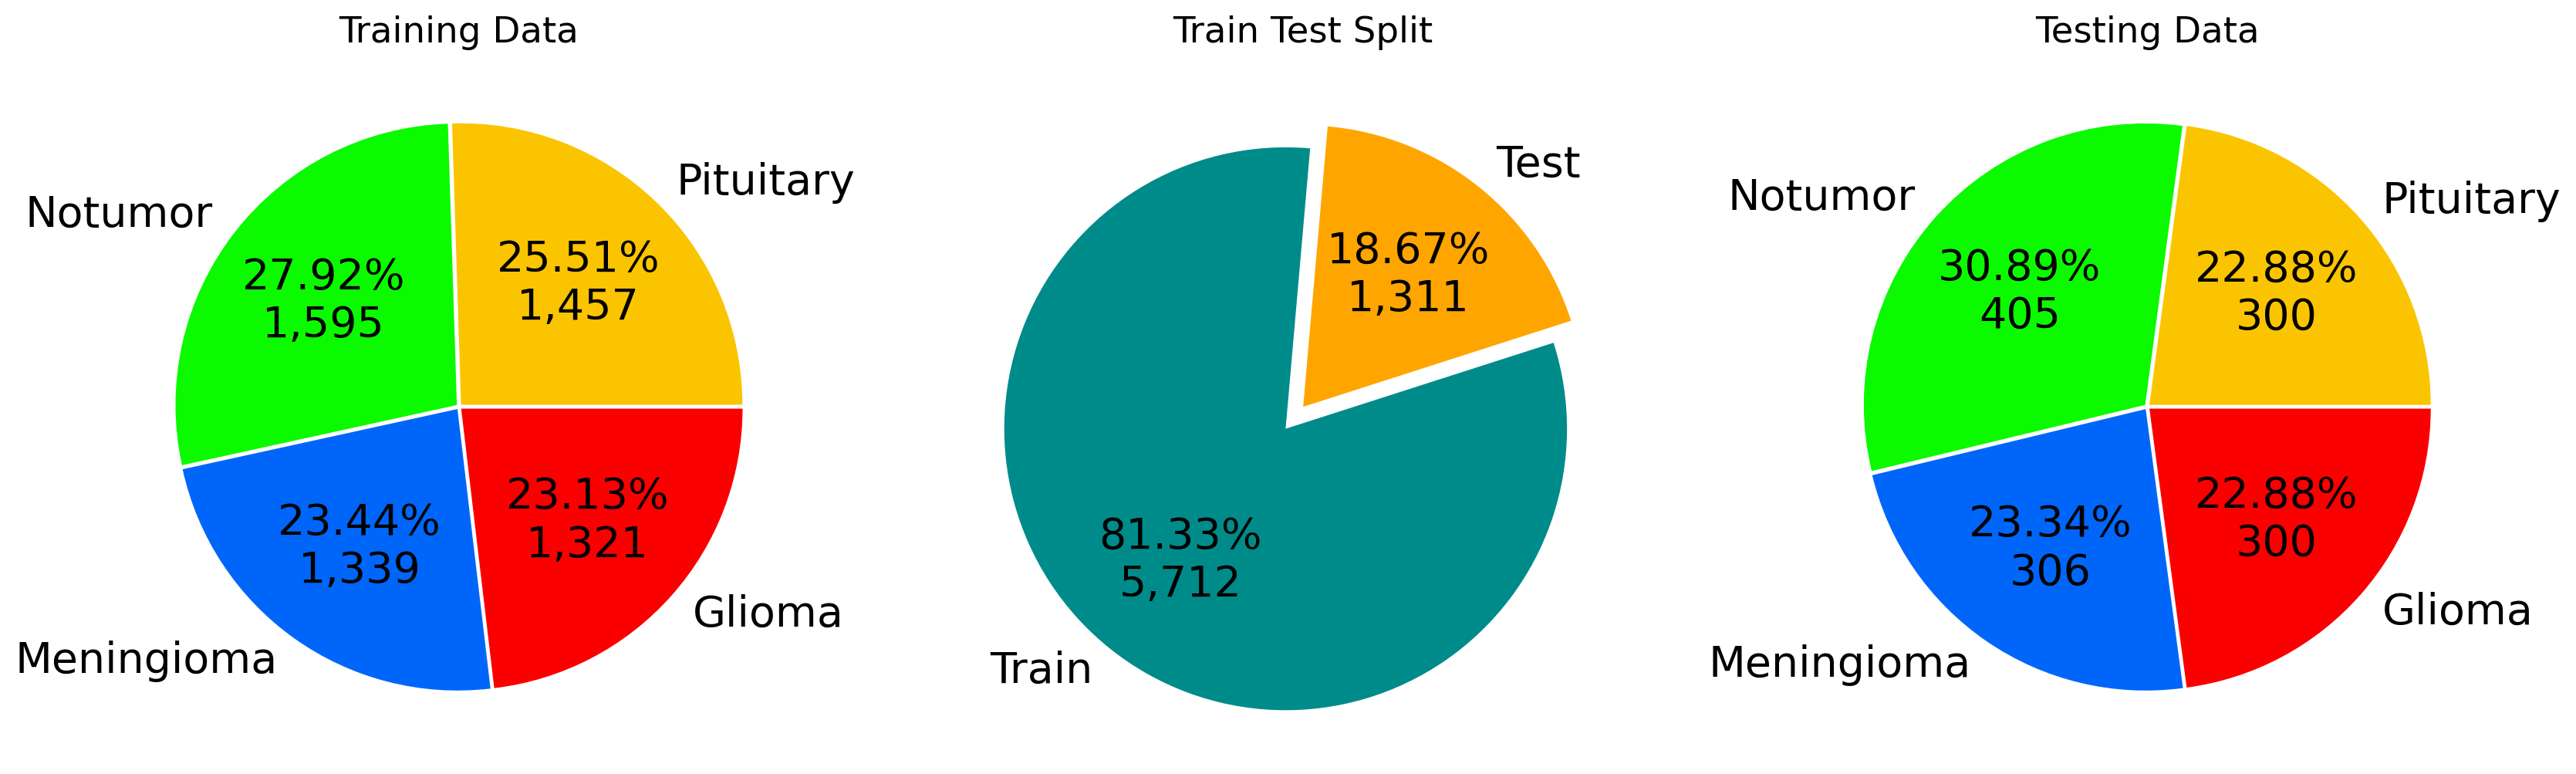

In [41]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Explode the slices slightly for better visualization
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)


if SAVE:
    plt.savefig('Training_data_pie.pdf')
plt.show()

x reshaped: (1, 150, 150, 3)


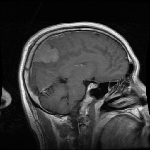

In [42]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [43]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """
    from keras.preprocessing.image import load_img
    import matplotlib.pyplot as plt

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()
    
    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()


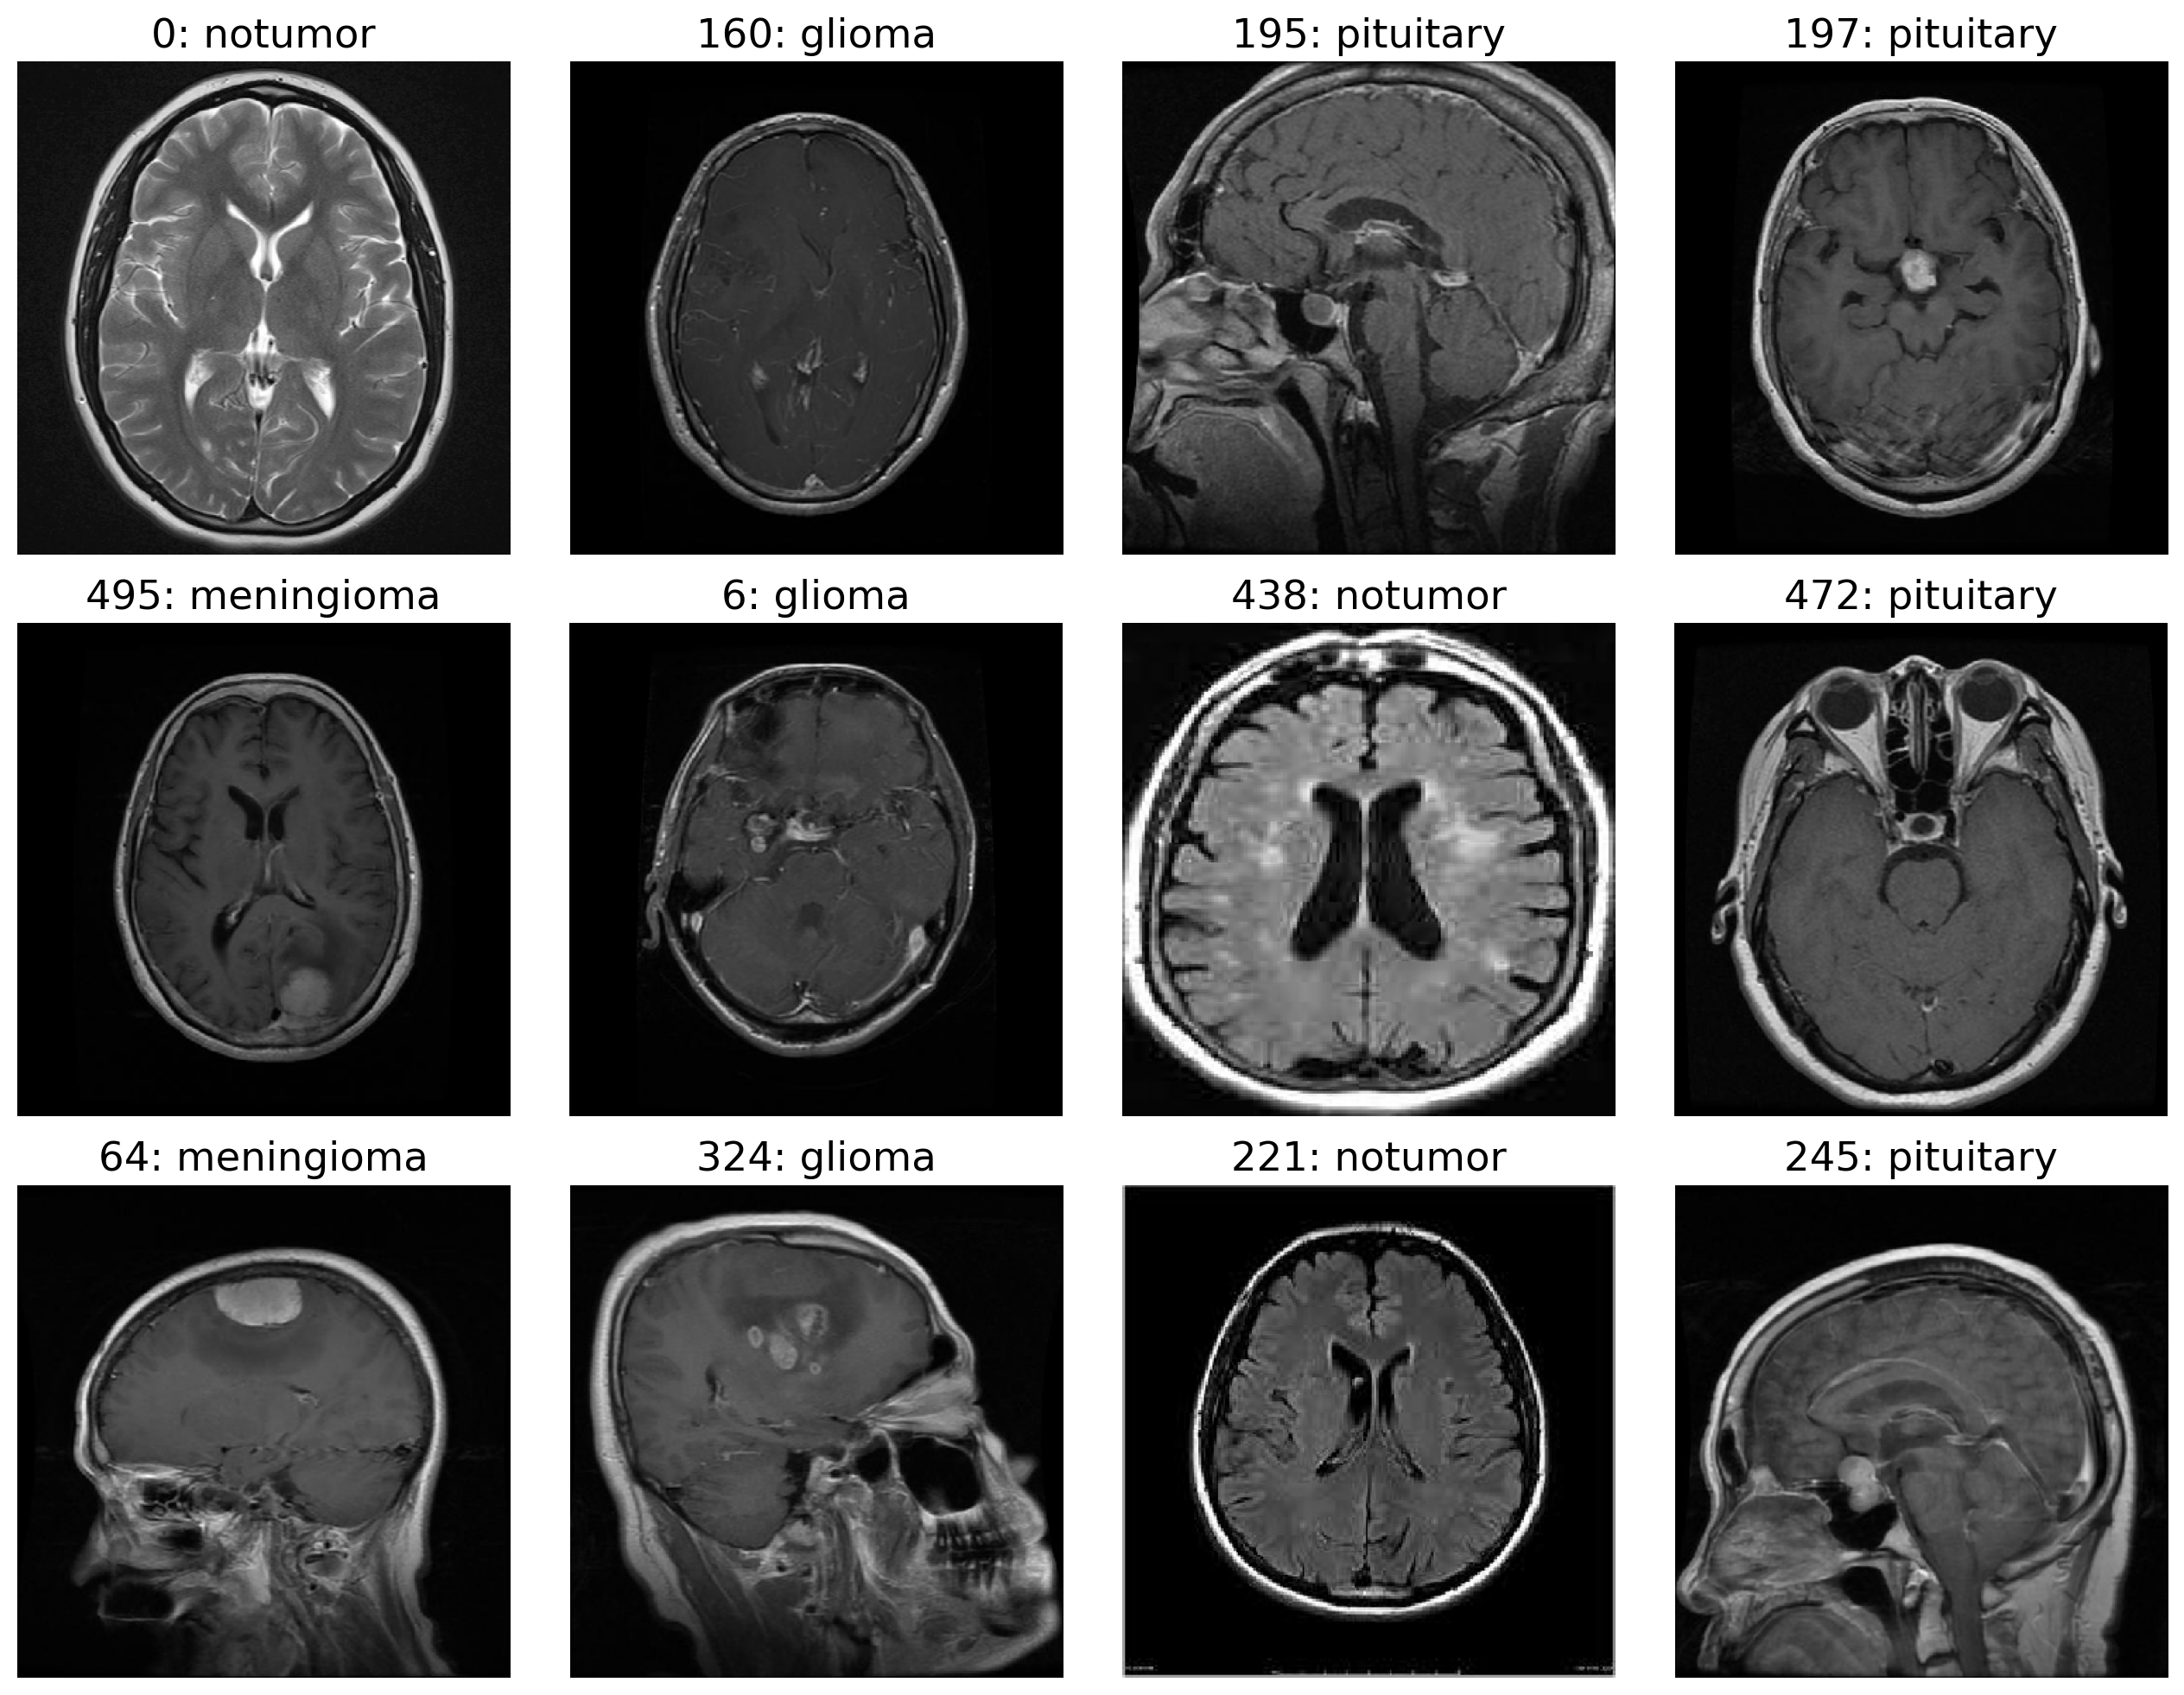

In [44]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths, 
            train_labels, 
            index_list=[0, 160, 195, 197,
                        495, 6, 438, 472,
                        64, 324, 221, 245], 
            im_size=350, 
            figsize=(13,10),
            save=SAVE)

In [45]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [46]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [47]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [48]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """
    
    # Generate augmented samples
    augmented_samples = next(train_generator)

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')
        
    plt.tight_layout()
        
    if save:
        plt.savefig('show_ImageDataGenerator.pdf')
        
    plt.show()

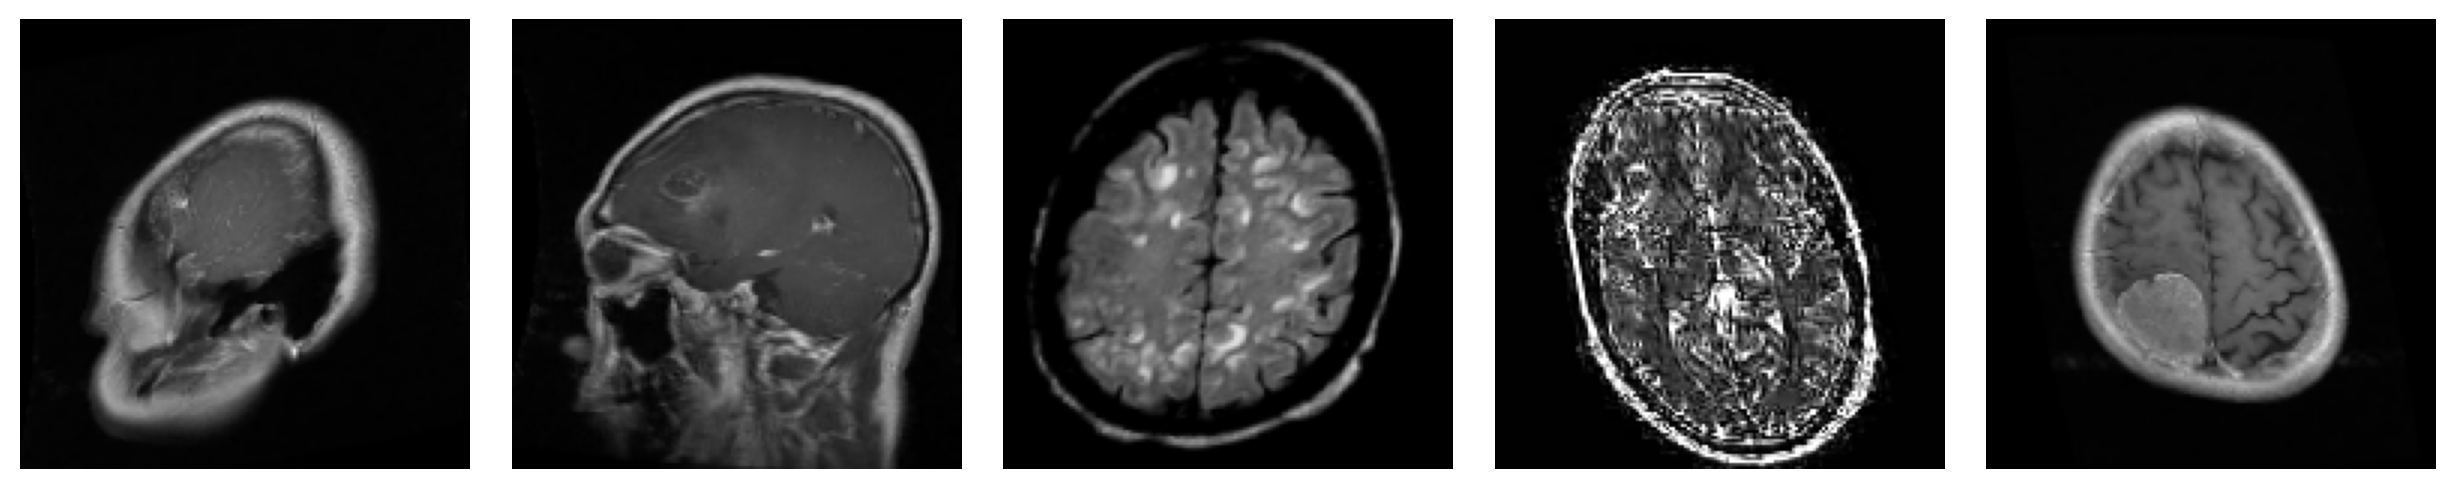

In [49]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=SAVE)

In [50]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# final model epochs
fm_epochs = 50

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Initial Model Epochs: {epochs}')
print(f'Final Model Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Initial Model Epochs: 40
Final Model Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [51]:
# –––––––––––––––––––––––––––––––––––––– #
# Output Images and Labels Visualization #
# –––––––––––––––––––––––––––––––––––––– #
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8), save=False):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)
    
    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")
        
        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)
        
    plt.tight_layout()
    if save:
        plt.savefig('plot_sample_predictions.pdf')
        
    plt.show()

    
# –––––––––––––––––––––––––––––––––––––– #
#            Confusion matrix            #
# –––––––––––––––––––––––––––––––––––––– #
def CM(CNN_model, test_generator):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)
    
    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")
        
    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")



In [52]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model architecture
model_1 = models.Sequential()

# Convolutional layer 1
model_1.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_1.add(Conv2D(64, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(Flatten())

# Fully connected layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.5, seed=SEED))
model_1.add(Dense(N_TYPES, activation="softmax"))

# Print model summary
model_1.summary()

# Compile the model
optimizer = Adam()
model_1.compile(optimizer=optimizer, 
                loss="categorical_crossentropy", 
                metrics=["accuracy"])


C:\Users\rahul\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

C:\Users\rahul\AppData\Roaming\Python\Python312\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


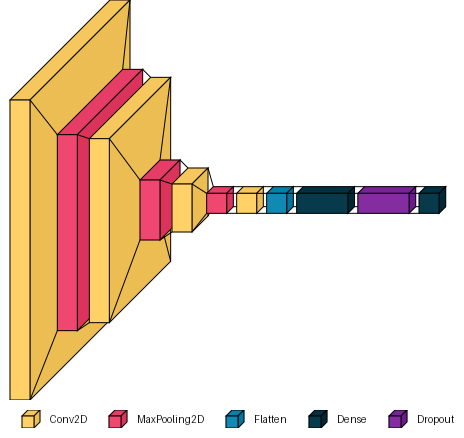

In [53]:
from visualkeras import layered_view

# Visualize the model
layered_view(model_1, legend=True, max_xy=300)

In [54]:
# Training the model
history_1 = model_1.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps)


C:\Users\rahul\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 99s 535ms/step - accuracy: 0.4289 - loss: 1.1198 - val_accuracy: 0.7422 - val_loss: 0.6682
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 35s 198ms/step - accuracy: 0.8125 - loss: 0.4534

C:\Users\rahul\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8125 - loss: 0.4534 - val_accuracy: 0.7078 - val_loss: 0.7783
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 92s 515ms/step - accuracy: 0.7846 - loss: 0.5465 - val_accuracy: 0.5570 - val_loss: 1.2990
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7188 - loss: 0.5942 - val_accuracy: 0.6555 - val_loss: 0.8742
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 96s 538ms/step - accuracy: 0.8201 - loss: 0.4543 - val_accuracy: 0.7734 - val_loss: 0.5501
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6250 - loss: 0.5349 - val_accuracy: 0.7766 - val_loss: 0.5469
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 92s 518ms/step - accuracy: 0.8680 - loss: 0.3530 - val_accuracy: 0.8219 - val_loss: 0.4123
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8438 - loss: 0.3401 - val_accuracy: 0.8250 - val_loss: 0.4011
Epoch 9/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 92s 516ms/step - accuracy: 0.8719 - loss: 0.3148 - val_accurac

## <b> 7.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Model Evaluation <b>

In [55]:
# Evaluate the model
loss, accuracy = model_1.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}") # 0.9875

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9605 - loss: 0.1519
Test Loss: 0.09293
Test Accuracy: 0.97734


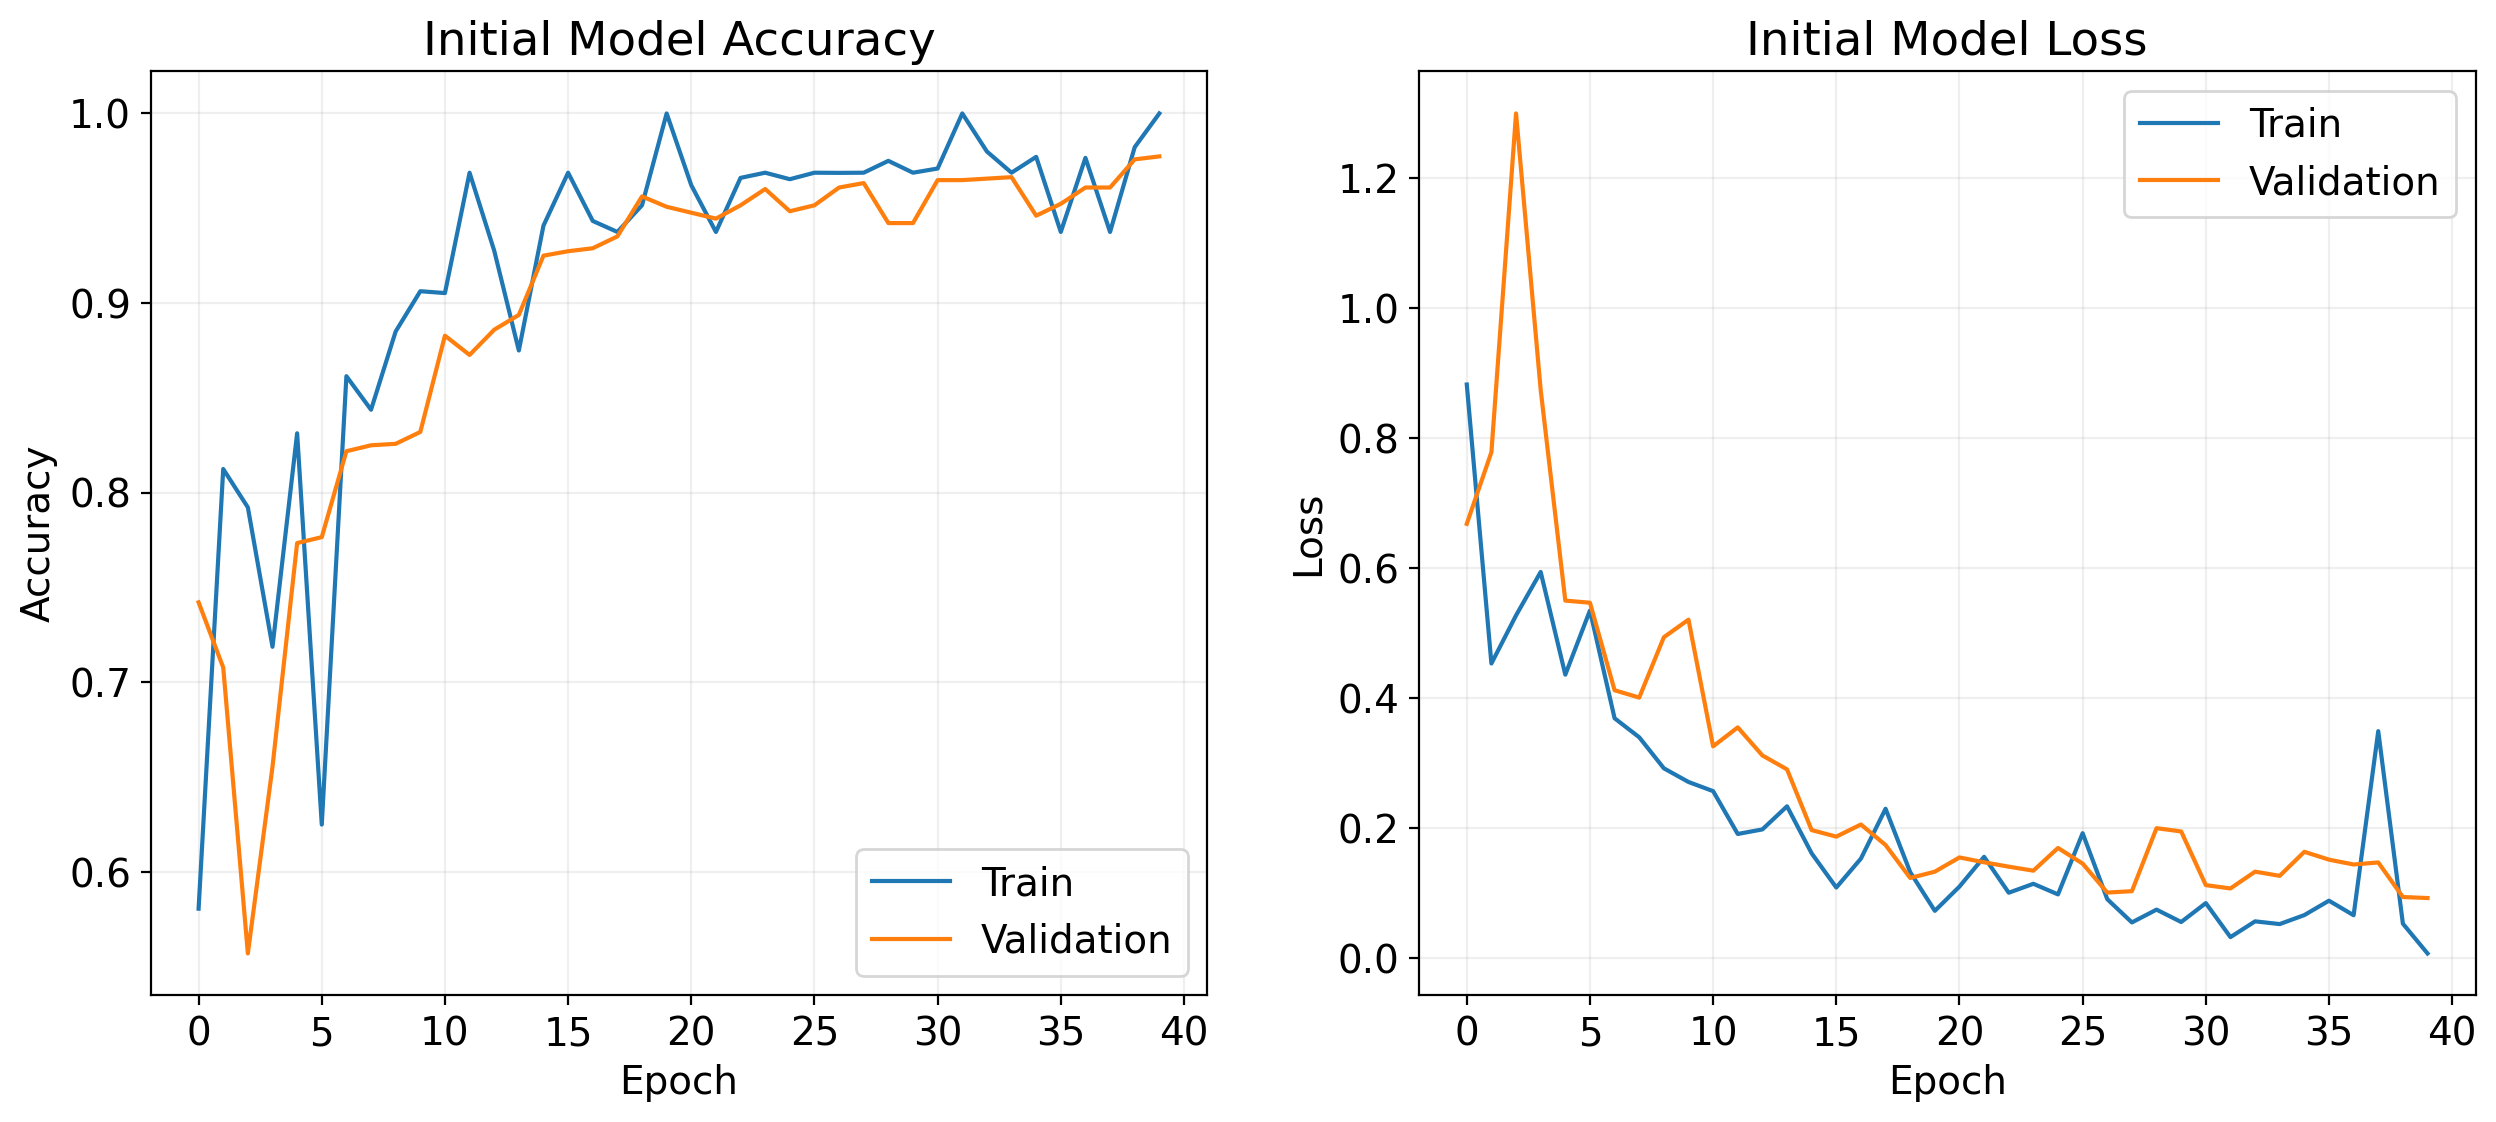

In [56]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_1.history['accuracy'])
ax[0].plot(history_1.history['val_accuracy'])
ax[0].set_title('Initial Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_1.history['loss'])
ax[1].plot(history_1.history['val_loss'])
ax[1].set_title('Initial Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)
if SAVE:
    plt.savefig('model_1_acc_loss.pdf')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step


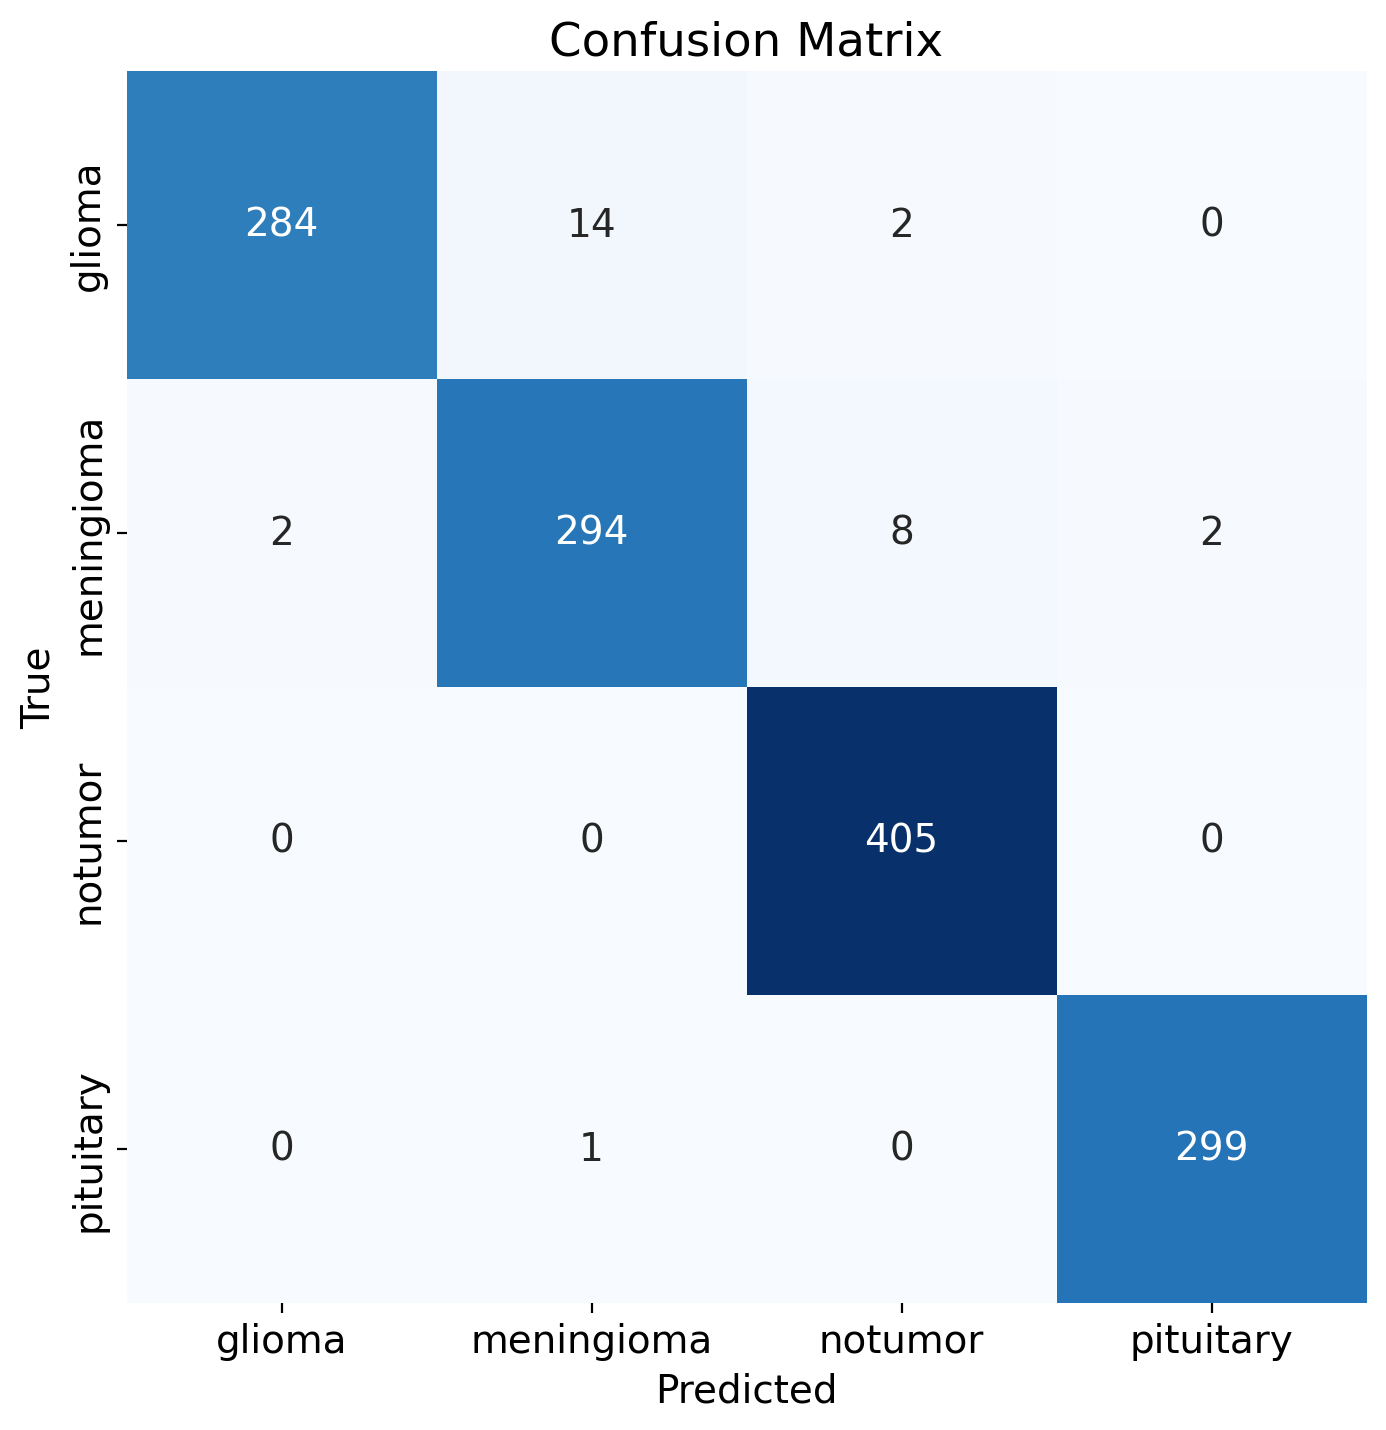

Class: Pituitary
Precision: 0.993
Recall: 0.947
F1-Score: 0.969

Class: Notumor
Precision: 0.951
Recall: 0.961
F1-Score: 0.956

Class: Meningioma
Precision: 0.976
Recall: 1.000
F1-Score: 0.988

Class: Glioma
Precision: 0.993
Recall: 0.997
F1-Score: 0.995


Accuracy: 0.978


In [57]:
# Plotting confusion matrix
confusion_matrix_1 = CM(CNN_model=model_1, test_generator=test_generator)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5, labels=class_indices_train_list, ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5, labels=class_indices_train_list, va='center')
if SAVE:
    plt.savefig('CM_plot_1.pdf')
plt.show()
   
# Showing metrix
calculate_metrics(confusion_matrix_1, categories=CLASS_TYPES)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step


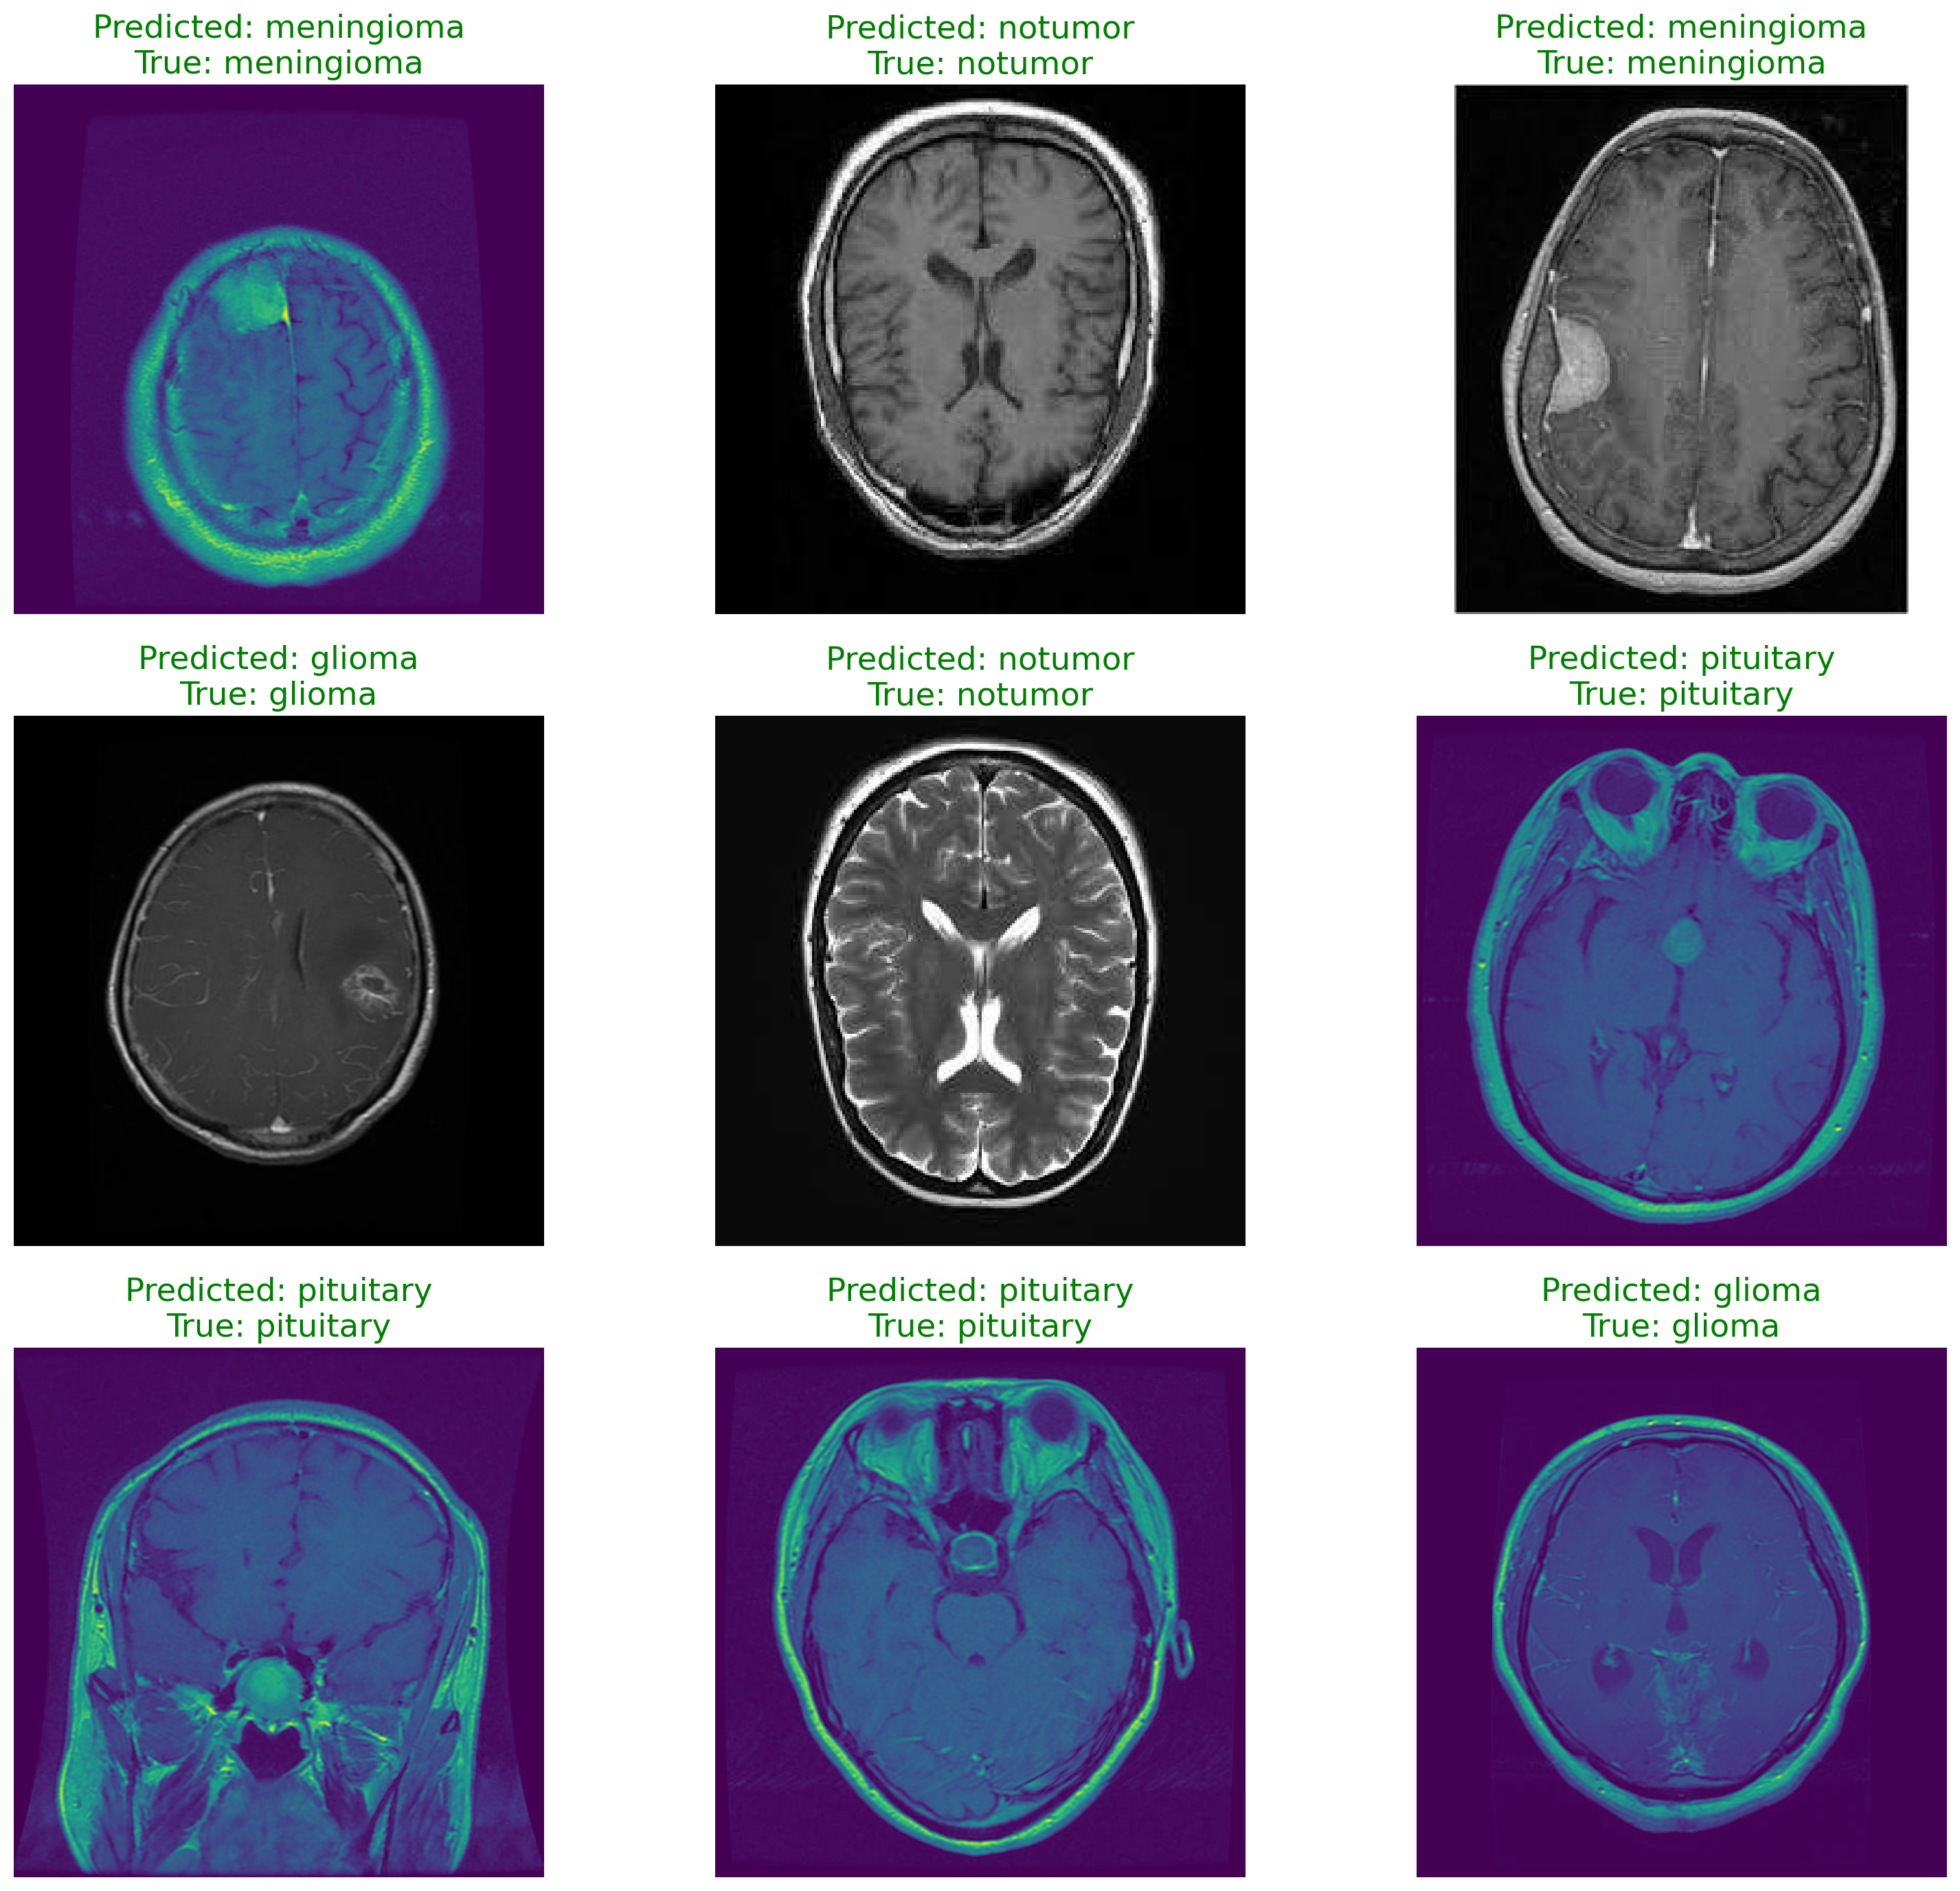

In [58]:
# Using functions in 6.1 for showing results
plot_sample_predictions(model=model_1, 
                        test_generator=test_generator, 
                        categories=class_indices_train_list,
                        test_dir=test_dir, 
                        num_samples=9,
                        figsize=(16, 14),
                        save=SAVE)

In [59]:
model_1.save("brain_tumor_model.keras")  # Recommended format


In [60]:
model_1.add(Dense(4, activation='softmax'))  # 4 classes


In [61]:
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
